# [데이콘] 소비자 데이터 기반 소비 예측 경진대회

[EDA](https://dacon.io/competitions/official/235893/codeshare/4871?page=1&dtype=recent)  
[데이터분석&예측](https://dacon.io/competitions/official/235893/codeshare/4870?page=1&dtype=recent)  
[앙상블 기법 활용](https://dacon.io/competitions/official/235893/codeshare/4887?page=1&dtype=recent)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
pd.set_option('mode.chained_assignment',  None) # error, warning 무시 --> 경고 끔

## 1. 데이터 불러오기

In [2]:
train = pd.read_csv('data/소비 예측 경진대회/train.csv')
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


In [3]:
train.shape

(1108, 22)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

## 2. 결측치 확인

In [5]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


## 3. 데이터 전처리
### 일자 분리
Dt_Customer 피쳐를 년도, 월, 일로 나누어 숫자형으로 변환한다.

In [6]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []
    
    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day
        
day, month, year = seperate_datetime(train)

train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,2014,6,10


In [7]:
# Dt_Customer 삭제
train = train.drop('Dt_Customer', axis = 1)
train.shape # (행, 열)

(1108, 24)

## 4. 피쳐 타입 분리

In [8]:
categorical = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
               'Complain', 'Response']

quantitative = ['Year_Birth', 'Income', 'year',	'month', 'day', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

print('카테고리형(정성적) columns : {}개'.format(len(categorical)))
print('수치형(정량적) columns : {}개'.format(len(quantitative)))

카테고리형(정성적) columns : 11개
수치형(정량적) columns : 11개


### 범주형 데이터 탐색

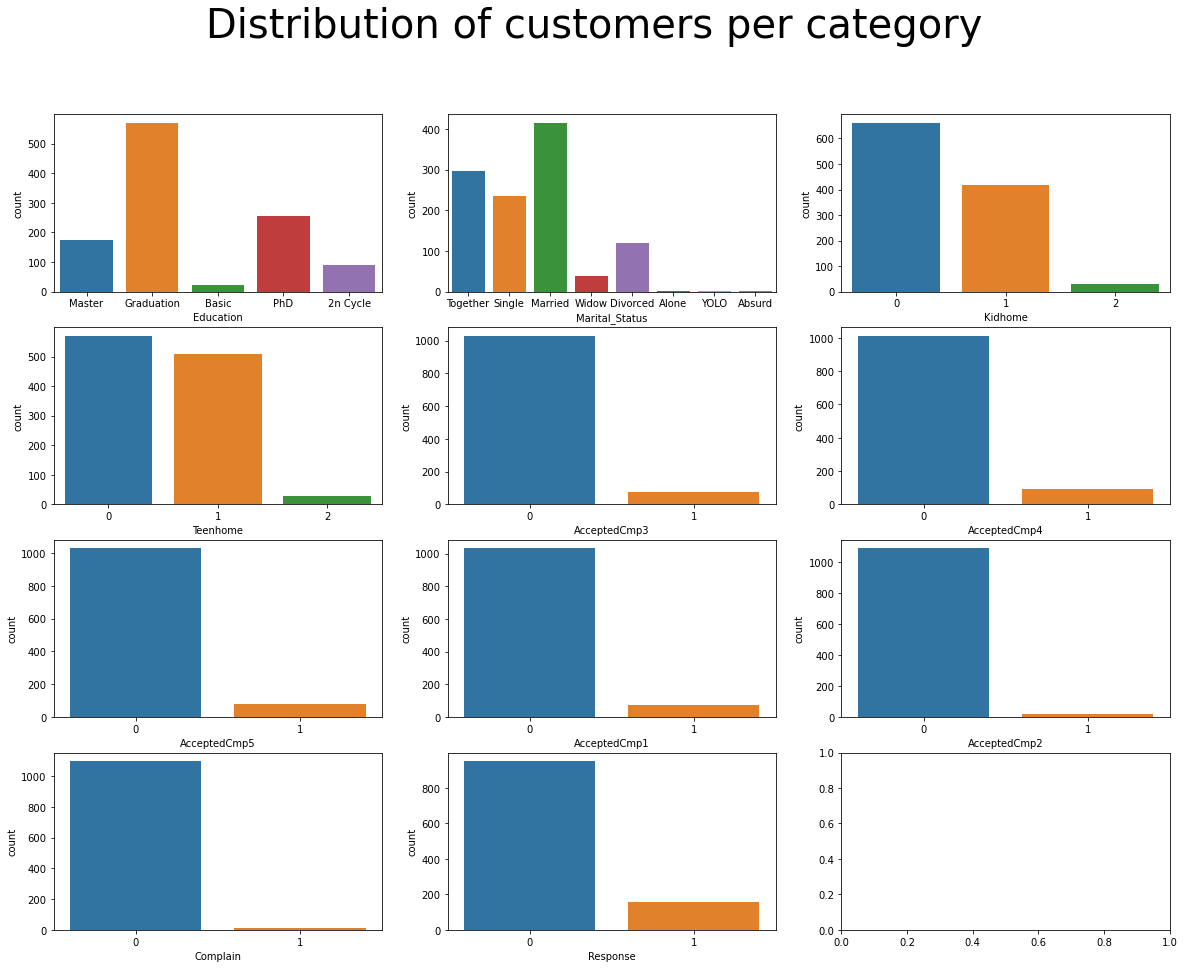

In [9]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (20,15))
fig.suptitle('Distribution of customers per category', fontsize = 40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)

plt.show()    

**[인사이트]**
1. Marital_Status에서 'Alone', 'YOLO', 'Absurd'는 데이터가 극히 작고 Single 범주에 포함되므로 Single로 통합시켜 분석할 수 있다.
2. Kidhome와 Teelhome에서 자녀 및 청소년을 2명 둔 사람은 소수이다.
3. AcceptedCmp1~5에서 보면, 1의 데이터가 적으므로 켐페인에 참여한 사람은 소수이다.

### 수치형 데이터 탐색

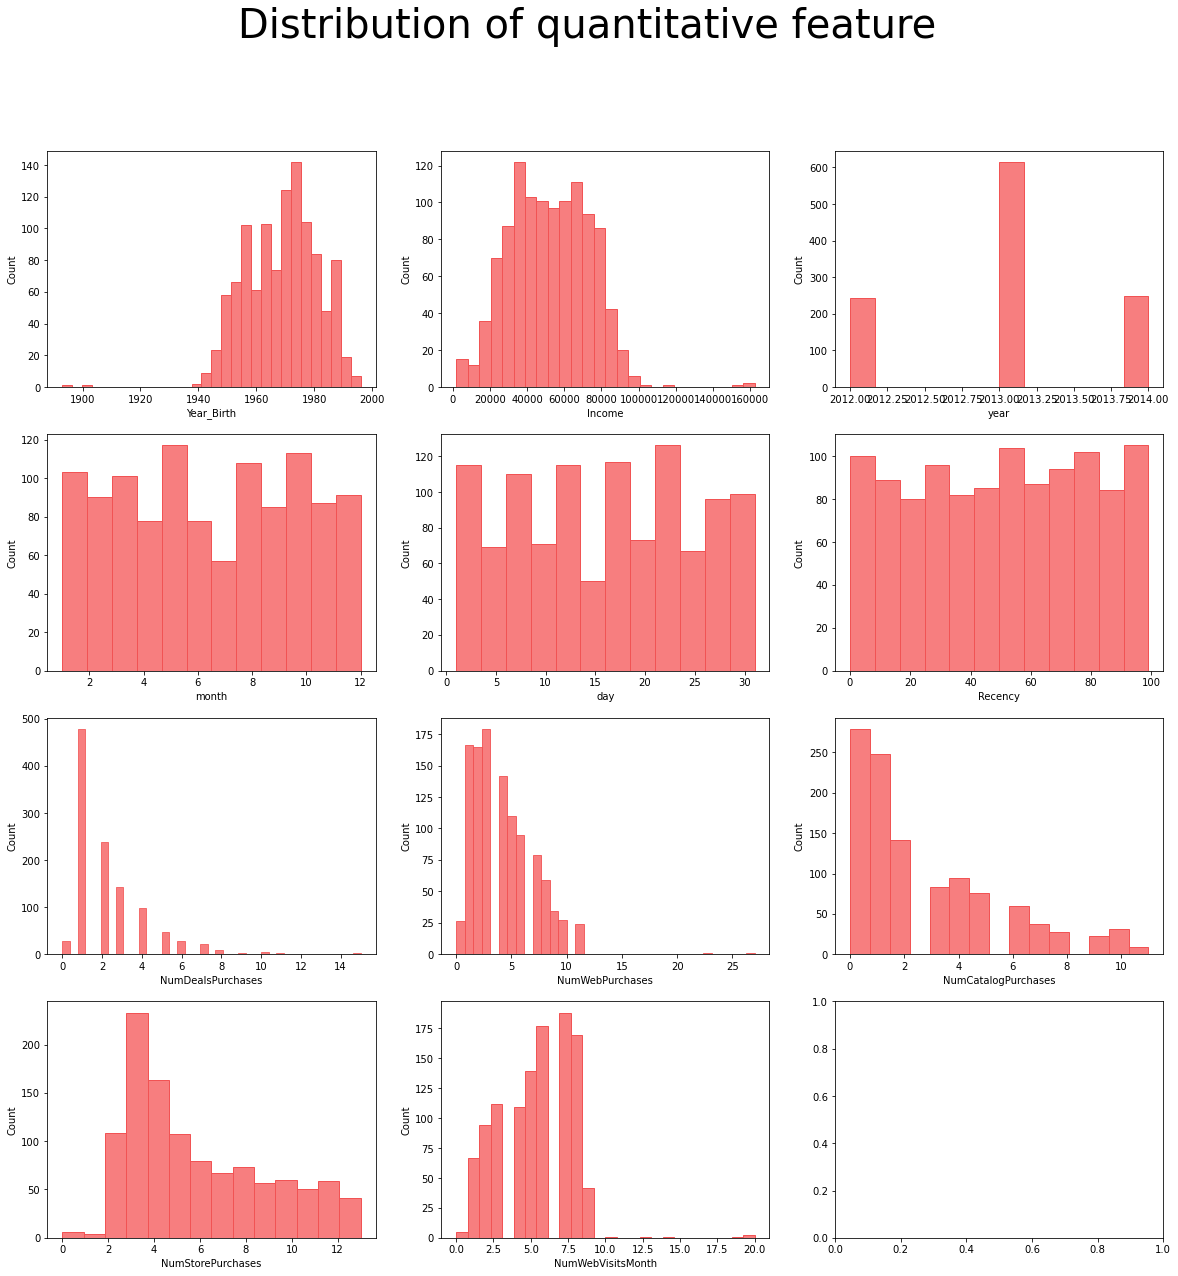

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Distribution of quantitative feature', fontsize = 40)

for ax, feature in zip(axes.flatten(), quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

**[인사이트]**
1. Year_Birth에서 1970 ~ 1980년생의 거래건수가 가장 많이 발생했다.
2. Income에서 30000~70000 사이 가구 소득의 거래건수가 가장 많았다고 볼 수 있다.
3. year에서 13년도에 가장 거래건수가 많았다.
4. Year_Birth, income, NumDealsPurchases, NumWebPurchases, NumWebVisitsMonth에서 이상치 발생 가능성을 볼 수 있다.

### 이상치 찾기

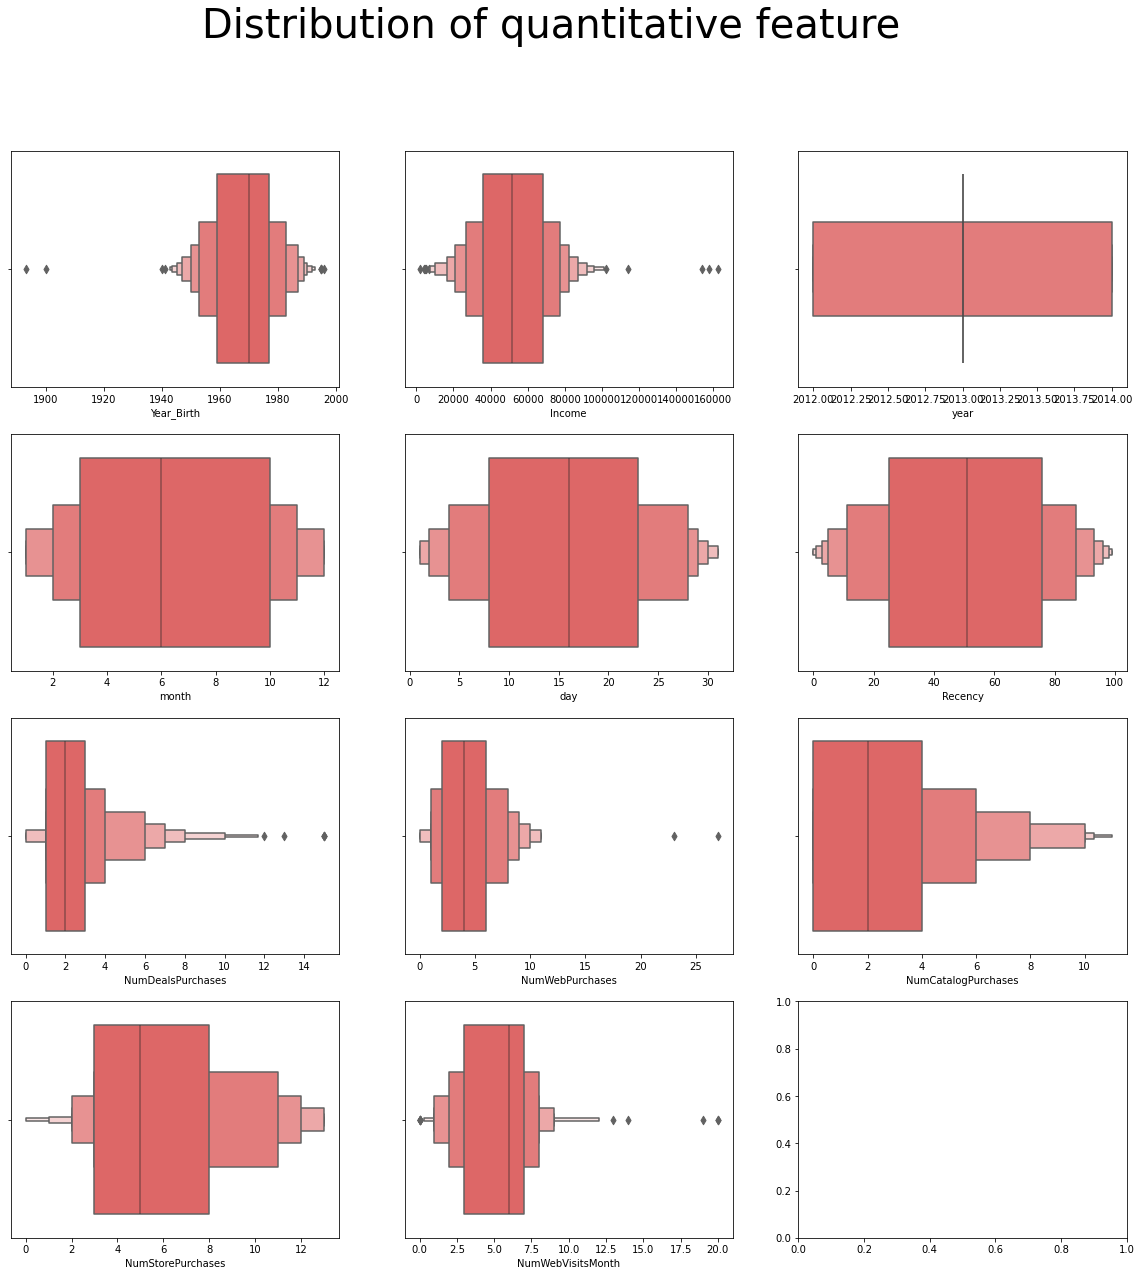

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Distribution of quantitative feature', fontsize = 40)

for ax, feature in zip(axes.flatten(), quantitative):
    sns.boxenplot(data = train, x = feature, ax=ax, color='#f15354')
plt.show()

In [12]:
from scipy import stats
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return lower_bound, upper_bound

outliers = train[quantitative].apply(lambda column: IQR(column))
print('Range of outliers by method')
outliers

Range of outliers by method


,Year_Birth,Income,year,month,day,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1932.0,-13066.25,2013.0,-7.5,-14.5,-51.5,-2.0,-4.0,-6.0,-4.5,-3.0
1,2004.0,117159.75,2013.0,20.5,45.5,152.5,6.0,12.0,10.0,15.5,13.0


날짜를 제외한 이상치 데이터 개수 확인

In [13]:
from scipy import stats
def IQRsum(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return ((column < lower_bound) | (column > upper_bound)).sum()

outliers = train[quantitative].drop(['year', 'month', 'day'], axis=1).apply(lambda column: IQRsum(column))
print('Range of outliers by method')
outliers

Range of outliers by method


Year_Birth              2
Income                  3
Recency                 0
NumDealsPurchases      46
NumWebPurchases         2
NumCatalogPurchases     9
NumStorePurchases       0
NumWebVisitsMonth       4
dtype: int64

NumDealsPurchases에서 가장 많은 이상치 46개가 발생했다.

### 상관관계 확인

In [14]:
quantitative.append('target')

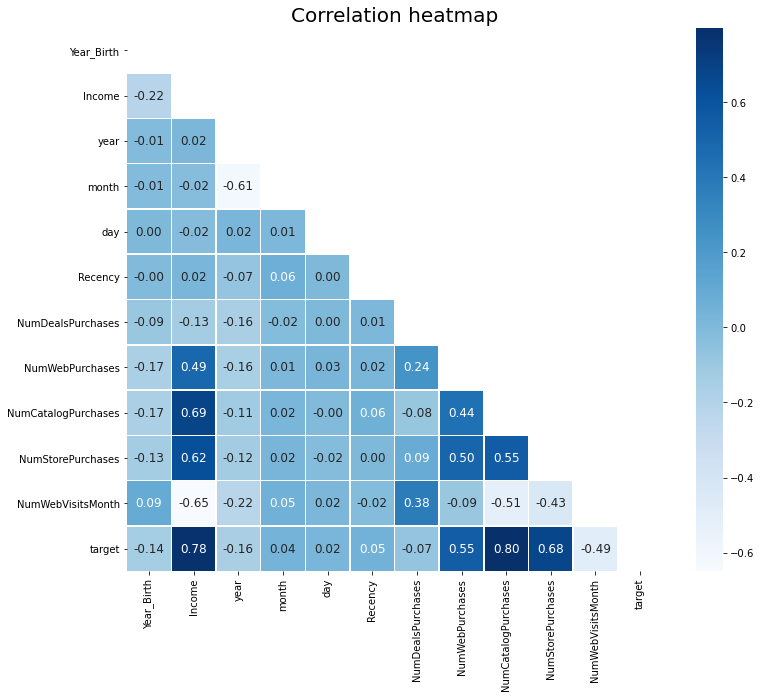

In [15]:
train_corr = train[quantitative]
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr28, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # np.triu_indices_from : mask에서 인덱스를 반환 (위쪽 삼각형에 True, 아래 삼각형에 False)

plt.figure(figsize=(12, 10))
sns.heatmap(data = corr28, cmap='Blues', mask=mask, fmt='.2f', annot = True, annot_kws={'size' : 12}, linewidth=.5)
plt.title('Correlation heatmap', fontsize=20)
plt.show()

feature가 많아서 헷갈리므로 Target과의 관계만 파악

In [16]:
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['target'].sort_values(ascending=False), columns=['target'])
df_temp28.style.background_gradient(cmap='viridis')

,target
target,1.000000
NumCatalogPurchases,0.798065
Income,0.784084
NumStorePurchases,0.677785
NumWebPurchases,0.546082
Recency,0.050873
month,0.037649
day,0.018917
NumDealsPurchases,-0.072802
Year_Birth,-0.136035


**[인사이트]**
1. 카탈로그를 사용한 구매 수가 많을수록 제품 소비량이 증가한다.
1. 상관계수가 0.3 이상이면 유의미한 양의 상관관계를 가진다.
1. 고객의 수입, 매장에서 직접 구매한 횟수, 웹사이트를 통한 구매 건수가 많을 수록 총 제품 소비량이 늘어난다.
1. 지난 달 회사 웹사이트 방문 횟수가 많을수록 제품 소비량지 줄어든다.

---

## 5. Feature Engineering

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Recency              1108 non-null   int64  
 8   NumDealsPurchases    1108 non-null   int64  
 9   NumWebPurchases      1108 non-null   int64  
 10  NumCatalogPurchases  1108 non-null   int64  
 11  NumStorePurchases    1108 non-null   int64  
 12  NumWebVisitsMonth    1108 non-null   int64  
 13  AcceptedCmp3         1108 non-null   int64  
 14  AcceptedCmp4         1108 non-null   int64  
 15  AcceptedCmp5         1108 non-null   i

Education, Marital_Status 변수 인코딩 수행 필요

In [18]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,0,0,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,1,1,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,1,2,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,2,2,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,3,0,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,2014,6,10


## 6. 변수 및 모델 정의

In [19]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 소비량 추출

In [20]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy()
train_data, val_data = train_test_split(data, test_size=.3)
train_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)

In [21]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (775, 24)
검증할 val 셋 :  (333, 24)


In [23]:
train_data_X = train_data.drop(['target', 'index'], axis =1)
train_data_y = train_data.target

val_data_X = val_data.drop(['target', 'index'], axis = 1)
val_data_y = val_data.target

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # 모델 정의
model.fit(train_data_X, train_data_y) # 학습

LinearRegression()

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.26946543847881343


대략 예측치와 실제값이 26.7% 정도의 오차율을 보인다는 것을 의미

### 예측값 눈으로 확인하기

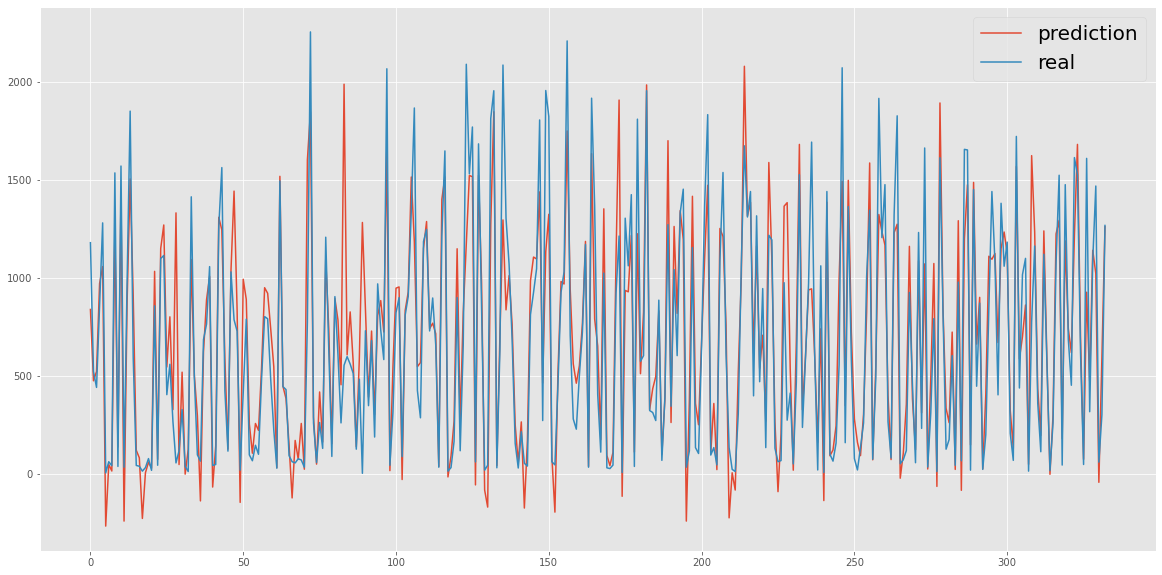

In [29]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label='prediction')
plt.plot(val_data_y, label='real')
plt.legend(fontsize = 20)
plt.show()

예측값이 실제 추세를 어느정도 따라가고 있음

## 7. train 셋 + val 셋 100% 활용하는 모델 만들기

In [30]:
train_X = train.drop(['target', 'id'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 소비량 추출

model = LinearRegression() # 모델 정의
model.fit(train_X, train_y) # 학습

LinearRegression()

## 8. Dacon 대회에 제출하기 (Submission)

In [32]:
test = pd.read_csv('data/소비 예측 경진대회/test.csv')

check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리

test = test.drop('Dt_Customer', axis = 1) #필요없는 열 삭제

#새로운 컬럼을 생성
test['year'] = year 
test['month'] = month
test['day'] = day

test = label_encoder(test, le) #카테고리형 피쳐 라벨인코딩

test = test.drop(['id'], axis = 1) #training 데이터에서 피쳐 추출

test.head()

결측치가 존재하지 않습니다


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,year,month,day
0,1979,1,1,57537.0,1,0,83,4,4,3,...,0,0,0,0,0,0,0,10,6,2013
1,1955,1,0,65748.0,0,1,58,2,2,4,...,0,0,0,0,0,1,0,15,4,2013
2,1984,1,2,55434.0,1,0,21,3,5,3,...,0,0,0,0,0,0,0,5,10,2013
3,1960,1,2,67716.0,0,1,8,4,7,4,...,0,1,0,0,0,0,0,10,1,2013
4,1976,1,0,85606.0,0,1,89,2,6,7,...,0,0,0,1,0,0,0,12,11,2012


In [33]:
prediction = model.predict(test)
prediction

array([162345.68392009, 161993.97021888, 162862.19005537, ...,
       161705.11973603, 162453.2450694 , 161234.14996264])

In [35]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('data/소비 예측 경진대회/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [36]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = prediction

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,162345.683920
1,1,161993.970219
2,2,162862.190055
3,3,162770.377762
4,4,162825.198507


In [37]:
# submission.to_csv("submission_baseline1.csv", index=False)

---
## **다른 모델링 활용**

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 다른 모델을 할당할 리스트 생성
models = []

# 모델들을 각각 할당하여 리스트에 추가
models.append(LinearRegression())
models.append(RandomForestRegressor(random_state=32))
models.append(GradientBoostingRegressor(learning_rate=.06, criterion='mae', random_state=32))

# 모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습
for model in models:
    model.fit(train_data_X, train_data_y)

In [40]:
print(models) #사용된 모델 확인

[LinearRegression(), RandomForestRegressor(random_state=32), GradientBoostingRegressor(criterion='mae', learning_rate=0.06, random_state=32)]


### 앙상블 추론
Voting 방식 중 Soft Voting 활용

- Hard Voting : 각 모델들의 결과물에 대한 최종 값을 투표를 해서 결정
- Soft Voting : 각 모델들의 결과물이 나올 확률 값이나 회귀 값을 평균을 내서 최종 값을 도출

In [42]:
# 전처리가 완료된 테스트 데이터 셋을 통해 학습한 모델로 추촌
prediction = None

# 학습된 모델들을 불러오기
for model in models:
    # 각 모델의 최종 회귀값들을 prediction에 모두 더함
    if prediction is None:
        prediction = model.predict(val_data_X)
    else:
        prediction += model.predict(val_data_X)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눔(= 평균)
prediction /= len(models)

In [45]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.19160482601836287


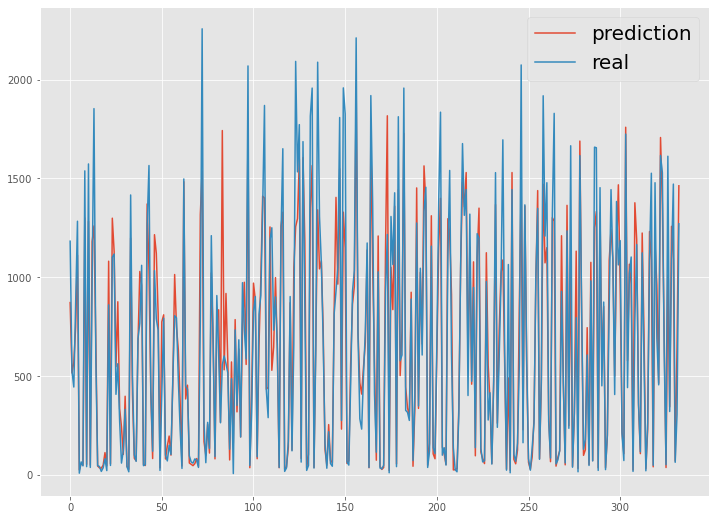

In [46]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 9))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [47]:
# train 셋 + val 셋 100% 활용하는 모델 만들기
train_X = train.drop(['target', 'id'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 소비량 추출

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(LinearRegression())
models.append(RandomForestRegressor(random_state=32))
models.append(GradientBoostingRegressor(learning_rate=0.06, criterion='mae', random_state=32))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_X, train_y)

In [52]:
test = pd.read_csv('data/소비 예측 경진대회/test.csv')

check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리

test = test.drop('Dt_Customer', axis = 1) #필요없는 열 삭제

#새로운 컬럼을 생성
test['year'] = year 
test['month'] = month
test['day'] = day

test = label_encoder(test, le) #카테고리형 피쳐 라벨인코딩

test = test.drop(['id'], axis = 1) #training 데이터에서 피쳐 추출

test.head()

결측치가 존재하지 않습니다


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,year,month,day
0,1979,1,1,57537.0,1,0,83,4,4,3,...,0,0,0,0,0,0,0,10,6,2013
1,1955,1,0,65748.0,0,1,58,2,2,4,...,0,0,0,0,0,1,0,15,4,2013
2,1984,1,2,55434.0,1,0,21,3,5,3,...,0,0,0,0,0,0,0,5,10,2013
3,1960,1,2,67716.0,0,1,8,4,7,4,...,0,1,0,0,0,0,0,10,1,2013
4,1976,1,0,85606.0,0,1,89,2,6,7,...,0,0,0,1,0,0,0,12,11,2012


In [55]:
# 전처리가 완료된 테스트 데이터 셋을 통해 학습한 모델로 추촌
pred = None

# 학습된 모델들을 불러오기
for model in models:
    # 각 모델의 최종 회귀값들을 prediction에 모두 더함
    if pred is None:
        pred = model.predict(test)
    else:
        pred += model.predict(test)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눔(= 평균)
pred /= len(models)

In [56]:
pred

array([54555.58736303, 54674.09257254, 54934.09448142, ...,
       53941.5723572 , 55137.49870935, 53840.49168258])

In [58]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('data/소비 예측 경진대회/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [59]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = pred

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,54555.587363
1,1,54674.092573
2,2,54934.094481
3,3,55163.524563
4,4,55229.428471


In [60]:
# submission.to_csv("submission_baseline1.csv", index=False)